# Learning to Reweight in MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import IPython

%matplotlib inline

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
trn_set_full = datasets.MNIST("data", train=True, transform=transform, download=True)
trn_indices = torch.cat([torch.arange(len(trn_set_full))[ trn_set_full.train_labels  == i ][:500*i] for i in range(10)])
trn_set = torch.utils.data.Subset( trn_set_full, trn_indices )
tst_set = datasets.MNIST("data", train=False, transform=transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 29168227.43it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 828274.82it/s]
1654784it [00:00, 11661380.60it/s]                           

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz



8192it [00:00, 378290.40it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


/home/vkonton/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [4]:
trn_loader = torch.utils.data.DataLoader(trn_set, batch_size=64, shuffle=True)
tst_loader = torch.utils.data.DataLoader(tst_set, batch_size=len(tst_set), shuffle=True)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)

In [6]:
def train():
    
    tst_data, tst_labels = next(iter(tst_loader))
    tst_data = tst_data.to(device)
    for i,(trn_data,_) in tqdm(enumerate(trn_loader)):
        net.train()
        trn_data = trn_data.to(device)

        opt.zero_grad()

        #Log-likelihood loss of the batch
        trn_out = net(trn_data)
        tst_out = net(tst_data)
        mx = torch.max(tst_out)
        loss1 = torch.mean( trn_out - mx )
        loss2 = torch.log( torch.mean(torch.exp(tst_out - mx)) )
        loss = -loss1 + loss2
        loss.backward()

        opt.step()
        losses.append(loss.item())
        if (i+1)%50 == 0:
            class_w, class_std = eval(tst_data, tst_labels)
            display_plot(class_w, class_std)

In [7]:
def eval(tst_data, tst_labels):
    tst_out = net(tst_data)
    classes = [[] for i in range(10)]
    for a,b in zip(tst_out, tst_labels):
        w,y = torch.exp(a).item(),b.item()
        classes[y].append(w)
    
    class_w = torch.tensor([torch.median(torch.tensor(classes[i])) for i in range(10)])
    class_std = torch.tensor([torch.std(torch.tensor(classes[i])) for i in range(10)])
    scale = torch.dot(class_w,torch.arange(10.0)) / torch.dot( class_w, class_w )
    class_w *= scale
    class_std *= scale
    return class_w, class_std
    
def display_plot(class_w, class_std):
    _,G = plt.subplots(1,2, figsize=(13,5))
    G[0].plot(losses)
    
    G[1].errorbar(torch.arange(10.0).numpy(),class_w.numpy(),fmt='o',yerr=class_std.numpy())
    G[1].plot(torch.arange(11.0).numpy())
    G[1].set_ylim([0,10])

    IPython.display.clear_output()
    plt.show()

def test():
    tst_data, tst_labels = next(iter(tst_loader))
    tst_data = tst_data.to(device)
    class_w, class_std = eval(tst_data, tst_labels)
    
    plt.errorbar(torch.arange(10.0).numpy(),class_w.numpy()/10,fmt='o',yerr=class_std.numpy()/10)
    plt.plot(torch.arange(10.0).numpy()/10)
    plt.xticks(torch.arange(10))
    ax1 = plt.gca()

    ax1.set_ylabel("Weights")
    ax1.set_xlabel("Digits")


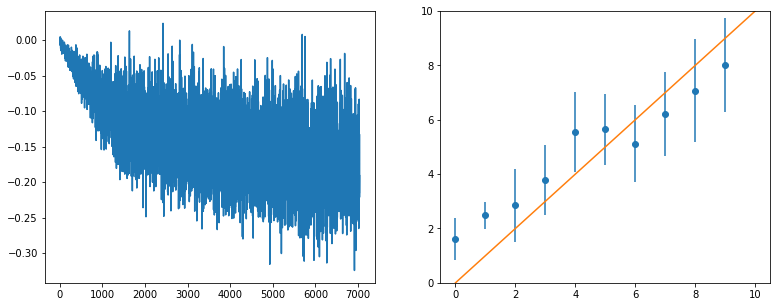

352it [00:47,  4.78it/s]


In [8]:
losses = []
for i in range(20):
    train()